<a href="https://colab.research.google.com/github/nana881023/Financial_Big_Data_Analysis/blob/main/Week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 作業1：
- 使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。


- yfinance
  - 下載2330從2024.1.1到今天的資料
  - 要輸出成表格
  - 包含日期、開、高、低、收、量

In [ ]:
!pip install yfinance
!pip install scikit-learn
!pip install tensorflow


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

In [ ]:
# 股票
stock_id="2330.TW"
start_date="2024-01-01" # 從2324.01.01開始
end_date=datetime.today().strftime("%Y-%m-%d")  # 今天

# 下載股票資料
data=yf.download(stock_id,start=start_date,end=end_date)
data=data.reset_index() # 重製索引，因為yf中日期通常是index，用重製的方法給真正的index

# 只保留日期和收盤價
data = data[['Date', 'Close']]
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price                       Date   Close
Ticker                           2330.TW
0      2024-01-02 00:00:00+00:00   593.0
1      2024-01-03 00:00:00+00:00   578.0
2      2024-01-04 00:00:00+00:00   580.0
3      2024-01-05 00:00:00+00:00   576.0
4      2024-01-08 00:00:00+00:00   583.0


- 資料預處理

In [ ]:
# 設定預測用的時間窗口大小
window_size = 20

# 正規化數據
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

# 創建輸入序列(X)和目標值(y)
X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

# 分割訓練集和測試集（使用80%數據作為訓練集）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重塑數據為LSTM所需的3D格式 [樣本數, 時間步長, 特徵數]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("訓練集大小:", X_train.shape)
print("測試集大小:", X_test.shape)

訓練集大小: (147, 20, 1)
測試集大小: (37, 20, 1)


- 建立和訓練LSTM模型

In [ ]:
# 建立LSTM模型
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])

# 編譯模型
model.compile(optimizer='adam', loss='mse')

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.2902 - val_loss: 0.0908
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0452 - val_loss: 0.0928
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0582 - val_loss: 0.0103
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0113 - val_loss: 0.0204
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0237 - val_loss: 0.0267
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0204 - val_loss: 0.0076
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0166 - val_loss: 0.0048
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0134 - val_loss: 0.0097
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0137 - val_loss: 0.0026
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0105 - val_loss: 0.0042
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0112 - val_loss: 0.0039
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0096 - val_l

- 進行預測和計算誤差

In [ ]:
# 預測
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# 反正規化
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform([y_train]).T
y_test_inv = scaler.inverse_transform([y_test]).T

# 計算預測誤差
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred))
mae = mean_absolute_error(y_test_inv, test_pred)
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Root Mean Squared Error: 27.85
Mean Absolute Error: 23.18


- 視覺化結果

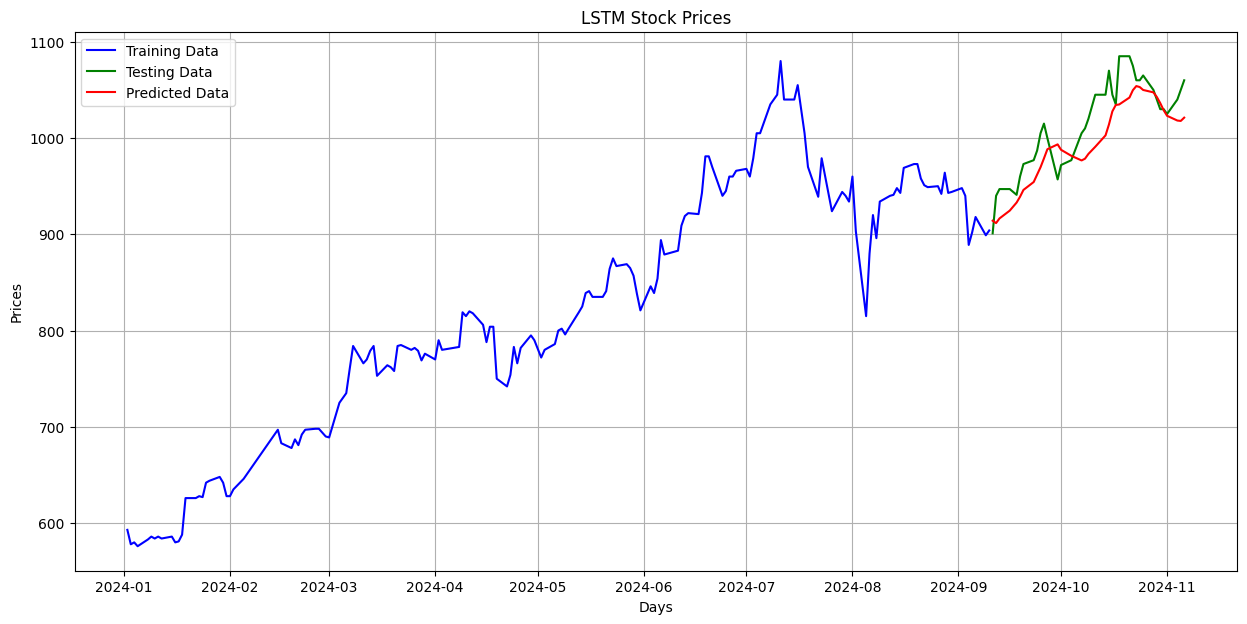

In [ ]:
# 創建時間序列索引
train_dates = data['Date'][window_size:train_size+window_size]
test_dates = data['Date'][train_size+window_size:]

# 繪製圖表
plt.figure(figsize=(15, 7))
plt.plot(data['Date'][:train_size+window_size], data['Close'][:train_size+window_size],
         label='Training Data', color='blue')
plt.plot(test_dates, data['Close'][train_size+window_size:],
         label='Testing Data', color='green')
plt.plot(test_dates, test_pred, label='Predicted Data', color='red')
plt.title('LSTM Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.grid(True)
plt.show()

## 作業2：
- 使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

In [ ]:
# 導入必要的套件
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


- 下載股票資料

In [ ]:
# 設定隨機種子確保可重複性
torch.manual_seed(42)
np.random.seed(42)

# 下載股票資料
stock_id = "2330.TW"
start_date = "2020-01-01"  # 較早的日期以獲取更多訓練數據
end_date = datetime.today().strftime("%Y-%m-%d")

# 下載股票資料
df = yf.download(stock_id, start=start_date, end=end_date)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

print("Data downloaded successfully!")
print(f"Data shape: {df.shape}")

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!
Data shape: (1177, 7)


- 資料預處理

In [ ]:
# 資料預處理參數
window_size = 20  # 設定窗口大小
prediction_days = 1  # 預測天數

# 只使用收盤價
data = df['Close'].values.reshape(-1, 1)

# 資料正規化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 創建訓練資料序列
X = []
y = []

for i in range(window_size, len(scaled_data) - prediction_days):
  X.append(scaled_data[i-window_size:i])
  y.append(scaled_data[i+prediction_days-1])

X = np.array(X)
y = np.array(y)

# 分割訓練集和測試集
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# 轉換為 PyTorch 張量並調整維度
X_train = torch.FloatTensor(X_train).squeeze(-1)  # [batch_size, seq_len]
y_train = torch.FloatTensor(y_train).squeeze()    # [batch_size]
X_test = torch.FloatTensor(X_test).squeeze(-1)    # [batch_size, seq_len]
y_test = torch.FloatTensor(y_test).squeeze()      # [batch_size]

print("Data preprocessing completed!")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Data preprocessing completed!
Training data shape: torch.Size([924, 20])
Testing data shape: torch.Size([232, 20])


- 定義Transformer模型

In [ ]:
class StockTransformer(nn.Module):
  def __init__(self, d_model=64, nhead=4, num_layers=2, dropout=0.1):
    super().__init__()

    # 特徵嵌入層
    self.embedding = nn.Linear(1, d_model)

    # 位置編碼
    self.pos_encoder = nn.Parameter(torch.randn(1, window_size, d_model))

    # Transformer 編碼器層
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=d_model*4,
        dropout=dropout,
        batch_first=True
    )
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    # 輸出層
    self.output_layer = nn.Linear(d_model, 1)

  def forward(self, x):
    # x shape: [batch_size, seq_len]
    x = x.unsqueeze(-1)  # [batch_size, seq_len, 1]
    x = self.embedding(x)  # [batch_size, seq_len, d_model]

    # 添加位置編碼
    x = x + self.pos_encoder

    # Transformer 編碼
    x = self.transformer(x)  # [batch_size, seq_len, d_model]

    # 取最後一個時間步的輸出
    x = x[:, -1, :]  # [batch_size, d_model]

    # 產生預測值
    x = self.output_layer(x)  # [batch_size, 1]
    return x.squeeze(-1)  # [batch_size]

# 初始化模型、損失函數和優化器
model = StockTransformer(d_model=64, nhead=4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model initialized!")

Model initialized!


- 建立和訓練模型

In [ ]:
# 訓練參數
num_epochs = 50
batch_size = 32

# 訓練紀錄
train_losses = []

print("Starting training...")
for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  for i in range(0, len(X_train), batch_size):
    # 取得批次資料
    batch_X = X_train[i:i+batch_size]
    batch_y = y_train[i:i+batch_size]

    # 清空梯度
    optimizer.zero_grad()

    # 前向傳播
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)

    # 反向傳播
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 計算平均損失
  avg_loss = total_loss / (len(X_train) // batch_size)
  train_losses.append(avg_loss)

  if (epoch + 1) % 5 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training completed!")

Starting training...
Epoch [5/50], Average Loss: 0.0180
Epoch [10/50], Average Loss: 0.0024
Epoch [15/50], Average Loss: 0.0063
Epoch [20/50], Average Loss: 0.0063
Epoch [25/50], Average Loss: 0.0011
Epoch [30/50], Average Loss: 0.0009
Epoch [35/50], Average Loss: 0.0036
Epoch [40/50], Average Loss: 0.0042
Epoch [45/50], Average Loss: 0.0055
Epoch [50/50], Average Loss: 0.0006
Training completed!


- 進行預測

In [ ]:
# 預測
model.eval()
with torch.no_grad():
  train_predict = model(X_train).numpy().reshape(-1, 1)
  test_predict = model(X_test).numpy().reshape(-1, 1)

# 反正規化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_data = scaler.inverse_transform(scaled_data)

# 計算預測誤差（確保長度匹配）
train_rmse = np.sqrt(((train_predict - original_data[window_size:train_size+window_size]) ** 2).mean())
test_rmse = np.sqrt(((test_predict - original_data[train_size+window_size:-prediction_days]) ** 2).mean())

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Testing RMSE: {test_rmse:.2f}')

# 印出形狀以便調試
print(f"\nData shapes:")
print(f"Train predict shape: {train_predict.shape}")
print(f"Test predict shape: {test_predict.shape}")
print(f"Original data shape: {original_data.shape}")

Training RMSE: 27.28
Testing RMSE: 151.20

Data shapes:
Train predict shape: (924, 1)
Test predict shape: (232, 1)
Original data shape: (1177, 1)


- 視覺化結果

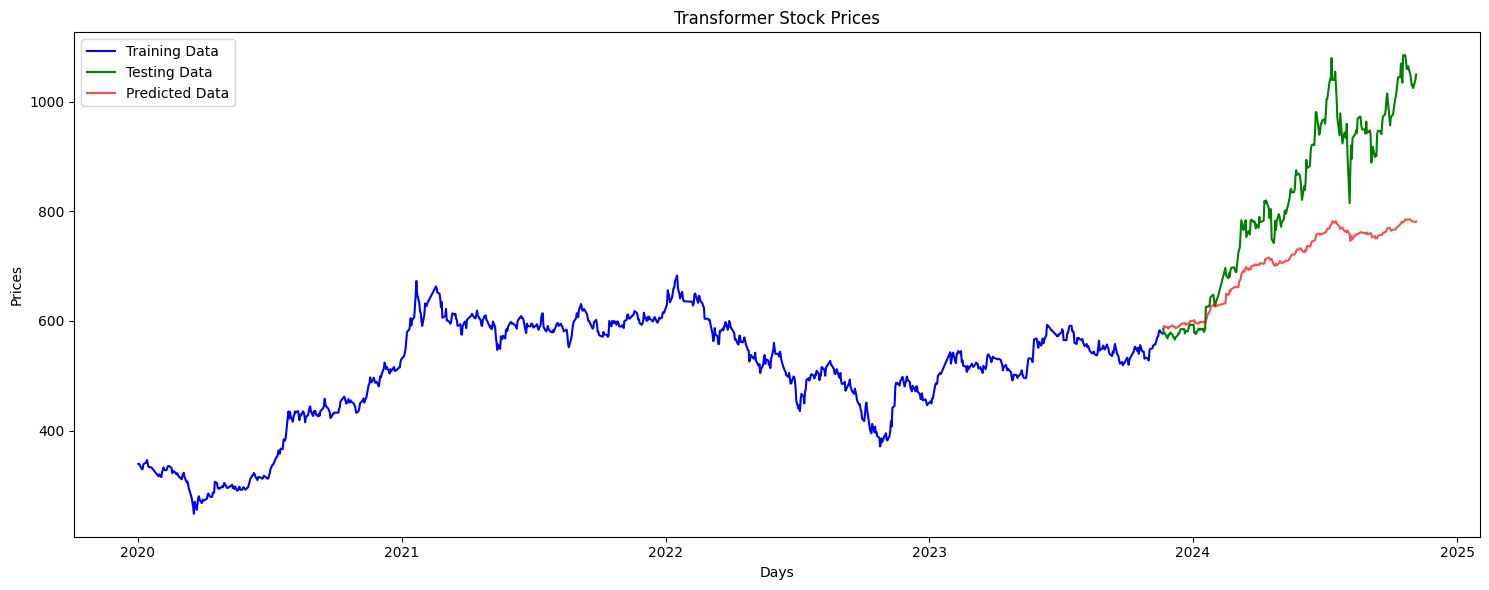

In [ ]:
plt.figure(figsize=(15, 6))

# 繪製訓練數據
plt.plot(df['Date'][:train_size+window_size],
    original_data[:train_size+window_size],
    label='Training Data',
    color='blue')

# 繪製測試數據
plt.plot(df['Date'][train_size+window_size:-prediction_days],
    original_data[train_size+window_size:-prediction_days],
    label='Testing Data',
    color='green')

# 只繪製測試集的預測結果
plt.plot(df['Date'][train_size+window_size:-prediction_days],
    test_predict,
    label='Predicted Data',
    color='red',
    alpha=0.7)

plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.tight_layout()
plt.show()